In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [3]:
EXAMPLES = True

# Simulation Data Analysis II

1) We present the normed euclidean distance between the $\chi_{1}$-angle of H294 in system A and B. The values were binned into 360 bins between -180 and 180.

In [4]:
def normed_euclidean_distance(x: np.ndarray, y: np.ndarray, axis=-1):
    assert x.shape[axis] == y.shape[axis]
    n = x.shape[axis]
    
    return (1/n) * np.sqrt(np.sum((x - y) ** 2, axis=axis))

In [5]:
files = ['ignore/anglesA/chi1HIS97.xvg', 'ignore/anglesB/chi1HIS97.xvg']
names = ['A', 'B']
dfs = [pd.read_csv(f, 
                   header=None, 
                   names=['time', n],
                   skiprows=17, 
                   index_col=0,
                   delim_whitespace=True) for n, f in zip(names, files)]
df = pd.concat(dfs, axis=1)

Text(0.5, 0, 'Chi1 (degree)')

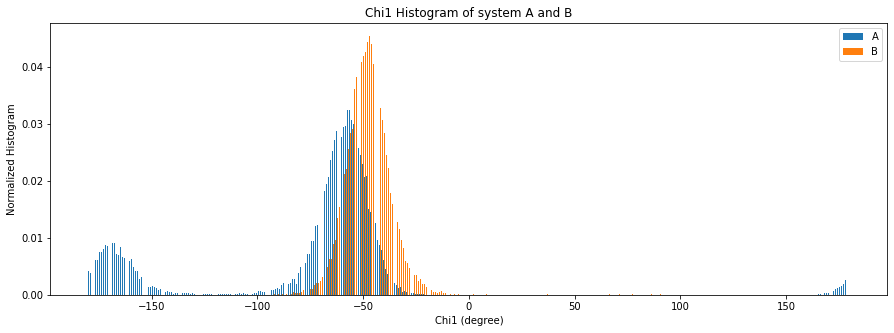

In [6]:
bins = np.linspace(-180, 180, 360)
fig = plt.figure(figsize=(15, 5))
plt.hist([df['A'], df['B']], 
         density=True, 
         bins=bins, 
         histtype='bar') # 'barstacked'
plt.title('Chi1 Histogram of system A and B')
plt.legend(['A', 'B'])
plt.ylabel('Normalized Histogram')
plt.xlabel('Chi1 (degree)')

In [7]:
bins = np.linspace(-180, 180, 360)
B, _ = np.histogram(df['A'], bins=bins, density=True)
A, _ = np.histogram(df['B'], bins=bins, density=True)

In [8]:
delta = normed_euclidean_distance(A, B)
print(f"The normed euclidean distance between the chi1 angles in system A and B is {delta}.")

The normed euclidean distance between the chi1 angles in system A and B is 0.0003258786872811465.


2) We estimate the Kullback-Leibler divergence between the histograms of the $\chi_{1}$-angle of H294 in system A and B. Note that $\ln(p)$ is not defined in areas where $p$ is zero or undefined. For this reason, we must restrict our calculation of the kl divergence to binned regions in which we have samples for both of our distributions (histograms).

In [9]:
def kl_divergence(p: np.ndarray, q: np.ndarray):
    assert p.shape == q.shape
    return np.sum(p * (np.log(p) - np.log(q)))

if EXAMPLES:
    # Generate samples
    A = np.random.randn(10000)*0.5 + 1
    B = np.random.rand(10000) # Note, this must cover the A dist.
    
    # they must be defined on the same region, so truncate the normal
    bmax, bmin = B.max(), B.min()
    A = np.array([i for i in A if (bmin < i) and (i < bmax)])
    
    # Find a density for the purposes of calculating kl_divergence
    bins = np.linspace(bmin, bmax, num=100)
    pA, _ = np.histogram(A, bins=bins, density=True)
    pB, _ = np.histogram(B, bins=bins, density=True)
    print(kl_divergence(pA, pB))

14.20942306517852


3) Mutual Information

In [10]:
def mutual_information(pxy: np.ndarray, px: np.ndarray, py: np.ndarray):
    assert px.shape == py.shape
    assert pxy.shape == (px.shape[0], py.shape[0])
    
    ln = np.log(pxy) - np.log(np.einsum('i,j', px, py))
    return np.einsum('ij,ij', pxy, ln)

# Simple Test.
if EXAMPLES:
    from scipy.special import softmax as softmax
    pq = softmax(np.random.rand(3,3))
    p = softmax(np.random.rand(3))
    q = softmax(np.random.rand(3))
    print(f"Independent case: {mutual_information(np.einsum('i,j', p, q), p, q)}")
    print(f"Randomly Dependent case: {mutual_information(pq, p, q)}")

Independent case: 0.0
Randomly Dependent case: 0.11917426248347907


In [11]:
def entropy(px: np.ndarray):
    return -np.sum(px * np.log(px))

def normalized_mutual_information(pxy: np.ndarray, px: np.ndarray, py: np.ndarray):
    return mutual_information(pxy, px, py) / np.min([entropy(i) for i in [px, py]])

# Simple Test.
if EXAMPLES:
    from scipy.special import softmax as softmax
    pq = softmax(np.random.rand(3,3))
    p = softmax(np.random.rand(3))
    q = softmax(np.random.rand(3))
    print(f"Independent case: {normalized_mutual_information(np.einsum('i,j', p, q), p, q)}")
    print(f"Randomly Dependent case: {normalized_mutual_information(pq, p, q)}")

Independent case: 0.0
Randomly Dependent case: 0.1261078659173065


In [12]:
files = ['ignore/anglesB/chi1HIS97.xvg', 'ignore/anglesB/chi2HIS97.xvg']
names = ['chi1', 'chi2']
dfs = [pd.read_csv(f, 
                   header=None, 
                   names=['time', n],
                   skiprows=17, 
                   index_col=0,
                   delim_whitespace=True) for n, f in zip(names, files)]
df = pd.concat(dfs, axis=1)